In [1]:
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
from sys import getsizeof

In [3]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow
import torch

In [4]:
min_lat = 25.84
max_lat = 49.38
min_lon = -124.67
max_lon = -66.95

n_lats = len(np.unique(np.round(np.arange(min_lat, max_lat, 0.01))))
n_lons = len(np.unique(np.round(np.arange(min_lon, max_lon, 0.01))))

In [50]:
def coord_to_onehot(coord):
    #Coordinate should be in [lat, lon] format
    lat = round(coord[0]) - round(min_lat)
    lon = abs(round(coord[1]) - round(min_lon))
    return (lat * n_lons) + lon

def onehot_to_coord(value):
    lon = value % n_lons
    lat = round((value - lon)/n_lons)
    return [round(lat) + round(min_lat), round(lon) + round(min_lon)]

In [112]:
def load_data(inputDir, n_files=-1, split=0.3):
    n_classes = n_lats*n_lons
    
    files = os.listdir(inputDir)
    np.random.shuffle(files)
    files = files[:n_files]
    points = [im.replace(' ', '') for im in files]
    points = np.array([[float(im.split(']')[0].split('[')[-1].split('-')[0]), -1 * float(im.split(']')[0].split('[')[-1].split('-')[1])] for im in points])
    Y = np.array([coord_to_onehot(coord) for coord in points])
    
    X = np.array([np.array(Image.open(f'{inputDir}/{image}').convert("RGB")).astype(np.uint8) for image in files]).astype(np.uint8)
    X = preprocess_input(X, data_format=None)
    return train_test_split(X, Y, test_size=split)

def display_image(img):
    return Image.fromarray(img)

In [88]:
def map_pred(pred, real=None):
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])

    m = Basemap(llcrnrlon=-120.211606,llcrnrlat=20.837377,urcrnrlon=-60.158958,urcrnrlat=50.384359,
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',area_thresh=1000.,projection='lcc',\
                lat_1=50,lon_0=-100.,ax=ax)

    
    m.drawmapboundary(fill_color='#0d0887')
    m.fillcontinents(color = '#0d0887',lake_color='#0d0887')

    lat, lon = np.meshgrid(np.linspace(round(min_lat), round(max_lat), n_lats), np.linspace(round(min_lon), round(max_lon), n_lons))
    lonm, latm = m(lon.reshape(-1), lat.reshape(-1))
    
    m.pcolormesh(lon, lat, np.transpose(pred.reshape(n_lats, n_lons)), latlon=True, zorder=2, cmap='plasma', shading='nearest')
    
    if real != None:
        lonm, latm = m(real[1], real[0])
        m.scatter(lonm, latm, marker = '*', c = '#00ff12', zorder=100, s=100, alpha=1)

    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    #return fig

In [119]:
X_train, X_test, y_train, y_test = load_data('ResizedImages', 10000, 0.2)

In [166]:
#Creating Neural Network model

n_classes = n_lats*n_lons

base_model = Xception(weights = 'imagenet', 
                      input_shape = X_train[0].shape, 
                      include_top=True)

x = base_model.output
#x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(n_classes, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = False

model = Model(inputs=base_model.input , outputs=predictions)
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy', metrics=['accuracy'])

n_epochs = 10

In [139]:
#Training tensors were too big to fit on my GPU
#X_train = X_train[:-1000]
#y_train = y_train[:-1000]

In [140]:
print(f'Estimated VRAM usage: {getsizeof(X_train) + getsizeof(y_train) + getsizeof(model):,} (No idea if accurate)')

Estimated VRAM usage: 304 (No idea if accurate)


In [167]:
X_train.shape

(4000, 299, 299, 3)

In [169]:
#with tensorflow.device("cpu:0"):
history = model.fit(X_train, y_train, epochs = n_epochs, verbose=2)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [143]:
pred = model.predict(X_test[0:1])

C:\Users\evan\AppData\Local\Temp/ipykernel_14708/3379853602.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lon, lat, np.transpose(pred.reshape(n_lats, n_lons)), latlon=True, zorder=2, cmap='plasma', shading='nearest')


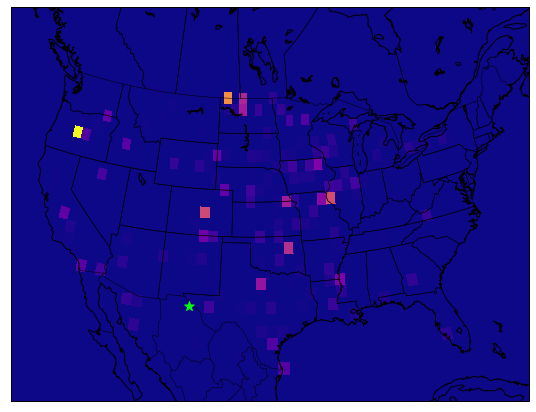

In [164]:
ind = 11
map_pred(model.predict(X_test[ind:ind+1]), onehot_to_coord(y_test[ind]))
#Image.fromarray(((X_test[ind] * 127) + 127).astype(np.uint8))

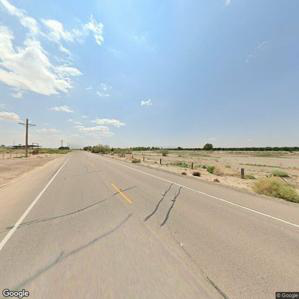

In [165]:
Image.fromarray(((X_test[ind] * 127) + 127).astype(np.uint8))

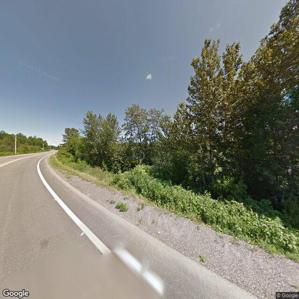

In [68]:
Image.fromarray(((X_test[0] * 127) + 127).astype(np.uint8))

C:\Users\evan\AppData\Local\Temp/ipykernel_14708/4109882491.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lon, lat, np.transpose(pred.reshape(n_lats, n_lons)), latlon=True, zorder=2, cmap='plasma', shading='nearest')


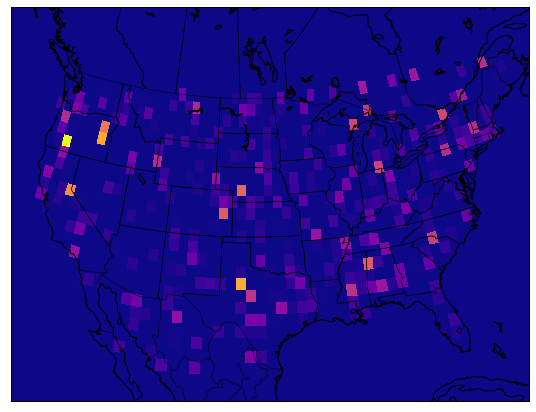

In [25]:
map_pred(pred)

In [46]:
model.predict(X_test) 

array([[1.2915161e-13, 1.9278951e-13, 1.2861793e-13, ..., 3.6544501e-13,
        2.9659454e-13, 6.1988554e-14],
       [3.9629203e-11, 6.3512119e-11, 1.2125900e-10, ..., 6.3177928e-11,
        1.5519204e-10, 5.1965179e-11],
       [8.8982109e-13, 1.7684698e-12, 1.1567775e-12, ..., 1.4308019e-12,
        1.2352646e-12, 1.2346121e-12],
       ...,
       [7.2276564e-12, 1.4241937e-11, 1.1987654e-11, ..., 1.3009619e-11,
        2.0473448e-11, 7.5468017e-12],
       [1.6408254e-16, 3.8305033e-17, 3.9338539e-16, ..., 1.4820681e-16,
        3.2296596e-16, 7.4714063e-17],
       [3.1562030e-14, 2.1621941e-14, 4.3301093e-14, ..., 2.9510879e-14,
        6.4990622e-14, 1.1409924e-14]], dtype=float32)

In [82]:
lat, lon = np.meshgrid(np.linspace(round(min_lat), round(max_lat), n_lats), np.linspace(round(min_lon), round(max_lon), n_lons))

In [37]:
files = os.listdir('ResizedImages')
np.random.shuffle(files)
#files = files[:n_files]
points = [im.replace(' ', '') for im in files]
points = np.array([[float(im.split(']')[0].split('[')[-1].split('-')[0]), -1 * float(im.split(']')[0].split('[')[-1].split('-')[1])] for im in points])

In [38]:
points[0]

array([ 29.47448242, -90.1996115 ])

In [133]:
x = np.copy(pred[0].reshape((n_lats, n_lons)))

In [134]:
x[np.argmax(x)]

IndexError: index 913 is out of bounds for axis 0 with size 24

In [45]:
#coord_to_onehot
#onehot_to_coord
print(f'{points[0]} -> {coord_to_onehot(points[0])}')
print(f'{177} -> {onehot_to_coord(212)}')

[ 29.47448242 -90.1996115 ] -> 177
177 -> [32, 42]
